In [21]:
# Import necessary libraries
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import numpy as np

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/divyahegde/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/divyahegde/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/divyahegde/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load dataset

In [22]:
# Load 20 Newsgroups dataset
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [23]:
[text for text in newsgroups_train.data][0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

## Pre-processing text

In [24]:
# Text preprocessing function
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the dataset
train_data = [preprocess_text(text) for text in newsgroups_train.data]
test_data = [preprocess_text(text) for text in newsgroups_test.data]



## Vectorization

In [25]:
# Vectorize using CountVectorizer with custom settings
vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
train_vectors = vectorizer.fit_transform(train_data)

## Modeling and training

In [26]:
# Train LDA model
def train_lda(n_topics, train_vectors):
    lda = LatentDirichletAllocation(n_components=n_topics, learning_decay=0.7, max_iter=10, random_state=42, n_jobs=-1)
    lda.fit(train_vectors)
    return lda

# Display top terms for each topic
def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))


In [27]:
# Train LDA with different numbers of topics
n_topics_list = [10, 20, 30]
lda_models = []
for n_topics in n_topics_list:
    lda_models.append(train_lda(n_topics, train_vectors))

# Display topics for each trained LDA model
for idx, lda_model in enumerate(lda_models):
    print(f"\nTop Terms for Model with {n_topics_list[idx]} Topics:\n")
    display_topics(lda_model, vectorizer.get_feature_names_out())



Top Terms for Model with 10 Topics:

Topic 0:
game team year play good season player win time pt
Topic 1:
god people say think jesus christian know believe thing like
Topic 2:
key car government use chip encryption year new like time
Topic 3:
armenian israel state turkish jew people israeli war government arab
Topic 4:
drive like know problem card thanks work use disk time
Topic 5:
space color file use window video problem nasa mode image
Topic 6:
gun firearm new file rate hockey player team period canada
Topic 7:
people know think right said say time like going year
Topic 8:
max max max bhj entry giz output file wm ah gk
Topic 9:
file window program use available information version image software server

Top Terms for Model with 20 Topics:

Topic 0:
thanks information email send know address space post mail computer
Topic 1:
god people say think jesus christian believe know thing life
Topic 2:
car space year like time engine launch new good satellite
Topic 3:
israel israeli jew arab

## Coherence score calculation

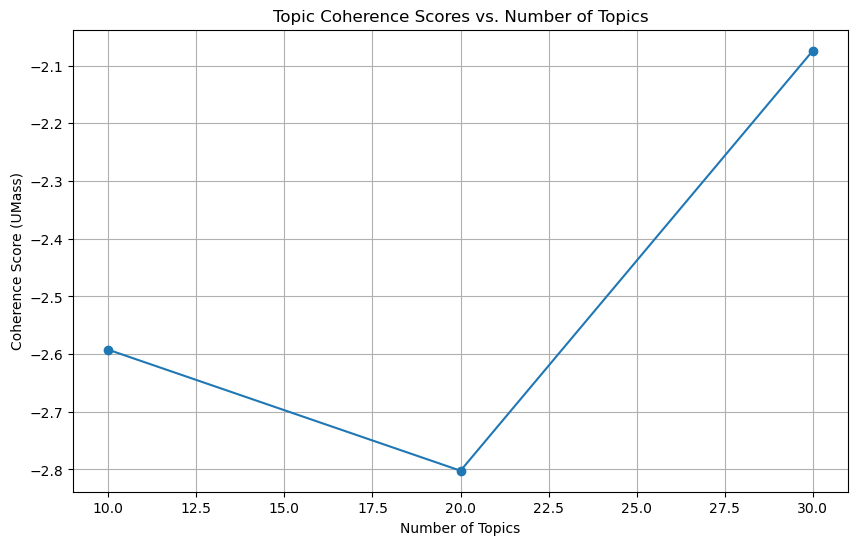

In [28]:
# Compute topic coherence using gensim
def compute_coherence_score(lda_model, texts, vectorizer):
    lda_topics = [[vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]] for topic in lda_model.components_]
    dictionary = Dictionary([text.split() for text in texts])
    corpus = [dictionary.doc2bow(text.split()) for text in texts]
    coherence_model = CoherenceModel(topics=lda_topics, texts=[text.split() for text in texts],
                                     dictionary=dictionary, coherence='u_mass')
    return coherence_model.get_coherence()

# Evaluate coherence scores
coherence_scores = []
for lda_model in lda_models:
    coherence_scores.append(compute_coherence_score(lda_model, train_data, vectorizer))

# Plot coherence scores
plt.figure(figsize=(10, 6))
plt.plot(n_topics_list, coherence_scores, marker='o')
plt.title('Topic Coherence Scores vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (UMass)')
plt.grid()
plt.show()

In [29]:
coherence_scores

[-2.592422470432427, -2.8022514318772074, -2.0740182721566067]